# Laptop Price Analysis: Data Cleaning and Preprocessing

**Objective:** This notebook details the data cleaning and preprocessing steps performed on a raw dataset of laptop information. The goal is to prepare a clean and structured dataset suitable for exploratory data analysis and predictive modeling of laptop prices.

**Dataset:** The dataset contains various specifications of laptops, including model, price, rating, and hardware details.

## 1. Data Loading and Initial Inspection

First, we load the necessary libraries and the raw dataset. An initial inspection of the data's shape, data types, and a sample of rows helps us understand its structure and identify immediate cleaning tasks.

In [37]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Load the raw dataset
df = pd.read_csv('../data/raw/laptop.csv')

print(f"Dataset shape: {df.shape}")
print("\nInitial data types and non-null counts:")
df.info()
print("\nSample of the raw data:")
df.sample(5)

Dataset shape: (920, 12)

Initial data types and non-null counts:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 920 entries, 0 to 919
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  920 non-null    int64  
 1   Model       920 non-null    object 
 2   Price       920 non-null    object 
 3   Rating      768 non-null    float64
 4   Generation  920 non-null    object 
 5   Core        920 non-null    object 
 6   Ram         920 non-null    object 
 7   SSD         920 non-null    object 
 8   Display     919 non-null    object 
 9   Graphics    920 non-null    object 
 10  OS          919 non-null    object 
 11  Warranty    915 non-null    object 
dtypes: float64(1), int64(1), object(10)
memory usage: 86.4+ KB

Sample of the raw data:


,Unnamed: 0,Model,Price,Rating,Generation,Core,Ram,SSD,Display,Graphics,OS,Warranty
522,522,Asus Vivobook Pro 15 M6500RC-HN741WS Laptop (A...,"₹72,990",66.0,6th Gen AMD Ryzen 7 6800H,"Octa Core, 16 Threads",16 GB LPDDR5 RAM,512 GB SSD,"15.6 inches, 1920 x 1080 pixels",4 GB NVIDIA GeForce RTX 3050,Windows 11 OS,1 Year Warranty
780,780,Ninkear A16 Gaming Laptop (AMD Ryzen 7 7735HS/...,"₹79,999",73.0,7th Gen AMD Ryzen 7 7735HS,"Octa Core, 16 Threads",32 GB DDR5 RAM,2 TB SSD,"16 inches, 2560 x 1600 pixels",AMD Radeon 680M,Windows 11 OS,1 Year Warranty
748,748,HP Envy x360 15-fh0016AU Laptop (AMD Ryzen 5 7...,"₹86,490",63.0,7th Gen AMD Ryzen 5 7530U,"Hexa Core, 12 Threads",16 GB LPDDR5 RAM,512 GB SSD,"15.6 inches, 1920 x 1080 pixels, Touch Screen",AMD Radeon AMD,Windows 11 OS,1 Year Warranty
462,462,HP Zbook FireFly 14 G8 4F0W6PA Laptop (11th Ge...,"₹89,900",65.0,11th Gen Intel Core i5 1135G7,"Quad Core, 8 Threads",16 GB DDR4 RAM,512 GB SSD,"14 inches, 1920 x 1080 pixels",Intel UHD Graphics,Windows 11 OS,1 Year Warranty
739,739,Lenovo IdeaPad Gaming 3 15ACH6 82K2022YIN Lapt...,"₹63,990",62.0,5th Gen AMD Ryzen 5 5600H,"Hexa Core, 12 Threads",8 GB DDR4 RAM,512 GB SSD,"15.6 inches, 1920 x 1080 pixels",4 GB NVIDIA GeForce RTX 3050,Windows 11 OS,1 Year Warranty


## 2. Data Cleaning

The data cleaning process involves several steps to handle inconsistencies, missing values, and incorrect data types.

### 2.1. Price Column Transformation

The 'Price' column is currently an object type containing currency symbols and commas. We need to convert it to a numerical format (USD) for analysis.

In [38]:
# Clean and convert the 'Price' column to a numeric USD value
df['Price_Cleaned'] = df['Price'].astype(str).str.replace('₹', '').str.replace(',', '').str.strip()
df['Price_Numeric_INR'] = pd.to_numeric(df['Price_Cleaned'], errors='coerce')

# Conversion rate (example rate, can be updated)
inr_to_usd_exchange_rate = 0.012
df['Price_USD'] = (df['Price_Numeric_INR'] * inr_to_usd_exchange_rate).round(2)

print("Price column successfully converted to USD.")
df[['Price', 'Price_USD']].head()

Price column successfully converted to USD.


,Price,Price_USD
0,"₹50,399",604.79
1,"₹23,990",287.88
2,"₹26,989",323.87
3,"₹69,990",839.88
4,"₹1,02,990",1235.88


### 2.2. Handling Jumbled Rows

Upon inspection, some rows have their data shifted across columns. We'll identify these rows and decide on a strategy to handle them.

In [39]:
# Identify jumbled rows by checking for unexpected patterns in key columns
jumbled_conditions = (
    ~df['Core'].astype(str).str.contains('Core|Threads', na=False) |
    ~df['Ram'].astype(str).str.contains('RAM', na=False) |
    ~df['SSD'].astype(str).str.contains('SSD|Disk', na=False) |
    ~df['Display'].astype(str).str.contains('inch|pixel', na=False) |
    ~df['OS'].astype(str).str.contains('OS', na=False) |
    ~df['Warranty'].astype(str).str.contains('Warranty', na=False)
)

jumbled_rows = df[jumbled_conditions]
jumbled_indices = jumbled_rows.index

percentage_jumbled = (len(jumbled_rows) / df.shape[0]) * 100
print(f"Found {len(jumbled_rows)} jumbled rows ({percentage_jumbled:.2f}% of the data).")

Found 24 jumbled rows (2.61% of the data).


**Decision:** Since the jumbled rows constitute a small percentage of the dataset and are difficult to correct systematically, we will drop them to maintain data integrity.

In [40]:
# Drop the identified jumbled rows
df.drop(jumbled_indices, inplace=True)
df.reset_index(drop=True, inplace=True)

print(f"Shape after dropping jumbled rows: {df.shape}")

Shape after dropping jumbled rows: (896, 15)


## 3. Feature Engineering

We will now extract structured information from existing columns to create new, more useful features for analysis.

### 3.1. Extracting Manufacturer and Processor Information

In [41]:
# Extract Manufacturer from the 'Model' string
df['Manufacturer'] = df['Model'].astype(str).str.split(' ', n=1, expand=True)[0].str.upper()

# Extract Processor Manufacturer from 'Generation' and 'Core' columns
processor_pattern = r'(Intel|AMD|Apple|Qualcomm|MediaTek|Kirin)'
df['Processor_Manufacturer'] = df['Generation'].astype(str).str.extract(processor_pattern, flags=re.IGNORECASE)
missing_mask = df['Processor_Manufacturer'].isnull()
df.loc[missing_mask, 'Processor_Manufacturer'] = df.loc[missing_mask, 'Core'].astype(str).str.extract(processor_pattern, flags=re.IGNORECASE)
df['Processor_Manufacturer'] = df['Processor_Manufacturer'].fillna('UNKNOWN')
df['Processor_Manufacturer'] = df['Processor_Manufacturer'].str.upper()

print("Manufacturer and Processor Manufacturer extracted.")
df[['Manufacturer', 'Processor_Manufacturer']].head()

Manufacturer and Processor Manufacturer extracted.


,Manufacturer,Processor_Manufacturer
0,HP,AMD
1,TECNO,INTEL
2,LENOVO,AMD
3,SAMSUNG,INTEL
4,XIAOMI,INTEL


### 3.2. Parsing Graphics Card Information

In [42]:
# Determine Graphics Type (Integrated vs. Dedicated) and Manufacturer
df['Graphics_Type'] = np.where(df['Graphics'].str.contains('NVIDIA|AMD Radeon RX|Quadro', case=False, na=False), 'Dedicated', 'Integrated')

def get_graphics_mfg(row):
    graphics_str = str(row['Graphics'])
    if re.search(r'NVIDIA|GeForce|RTX|Quadro', graphics_str, re.IGNORECASE): return 'NVIDIA'
    if re.search(r'AMD|Radeon', graphics_str, re.IGNORECASE): return 'AMD'
    if re.search(r'Intel|Iris|UHD', graphics_str, re.IGNORECASE): return 'INTEL'
    if re.search(r'Apple', graphics_str, re.IGNORECASE): return 'APPLE'
    return 'OTHER'

df['Graphics_Manufacturer'] = df.apply(get_graphics_mfg, axis=1)

# Extract Graphics Memory for dedicated cards
df['Graphics_Memory_GB'] = df['Graphics'].str.extract(r'(\d+)\s*GB', expand=False).astype(float)

print("Graphics information parsed.")
df[['Graphics_Type', 'Graphics_Manufacturer', 'Graphics_Memory_GB']].head()

Graphics information parsed.


,Graphics_Type,Graphics_Manufacturer,Graphics_Memory_GB
0,Dedicated,AMD,4.0
1,Integrated,INTEL,NaN
2,Integrated,AMD,NaN
3,Integrated,INTEL,NaN
4,Dedicated,NVIDIA,8.0


### 3.2.1. Imputing Missing Graphics Memory

The `Graphics_Memory_GB` column has missing values for laptops with 'Integrated' graphics, as they do not have dedicated video memory. We will impute these missing values with 0.

In [43]:
# Impute missing Graphics_Memory_GB with 0 for integrated cards
df['Graphics_Memory_GB'] = df['Graphics_Memory_GB'].fillna(0)

print("Missing graphics memory imputed for integrated cards.")
print(f"Remaining nulls in 'Graphics_Memory_GB': {df['Graphics_Memory_GB'].isnull().sum()}")

Missing graphics memory imputed for integrated cards.
Remaining nulls in 'Graphics_Memory_GB': 0


### 3.3. Parsing Display Features

In [44]:
# Extract Screen Size, Resolution, and Touchscreen capability
df['Screen_Size_inches'] = df['Display'].str.extract(r'(\d+\.?\d*)\s*inches', expand=False).astype(float)
resolution = df['Display'].str.extract(r'(\d+)\s*x\s*(\d+)', expand=True)
df['Resolution_Width'] = pd.to_numeric(resolution[0], errors='coerce')
df['Resolution_Height'] = pd.to_numeric(resolution[1], errors='coerce')
df['Touchscreen'] = df['Display'].str.contains('Touch Screen', case=False, na=False)

# Impute the few missing resolution values with the median
df['Resolution_Width'] = df['Resolution_Width'].fillna(df['Resolution_Width'].median())
df['Resolution_Height'] = df['Resolution_Height'].fillna(df['Resolution_Height'].median())

print("Display features extracted.")
df[['Screen_Size_inches', 'Resolution_Width', 'Resolution_Height', 'Touchscreen']].head()

Display features extracted.


,Screen_Size_inches,Resolution_Width,Resolution_Height,Touchscreen
0,15.6,1920.0,1080.0,True
1,15.6,1920.0,1080.0,False
2,15.6,1920.0,1080.0,False
3,13.3,1080.0,1920.0,False
4,16.1,2560.0,1600.0,False


### 3.4. Parsing Other Features

#### 3.4.1. Operating System

In [45]:
# Extract the main OS from the 'OS' string
df['OS_Clean'] = df['OS'].str.extract(r'(Windows|Mac|Chrome)')[0].fillna('Other')

print("Operating System cleaned.")
df[['OS', 'OS_Clean']].head()

Operating System cleaned.


,OS,OS_Clean
0,Windows 11 OS,Windows
1,Windows 11 OS,Windows
2,Windows 11 OS,Windows
3,Windows 11 OS,Windows
4,Windows 11 OS,Windows


#### 3.4.2. RAM

In [46]:
# Extract RAM size and type
df['RAM_GB'] = df['Ram'].str.extract(r'(\d+)\s*GB')[0].astype(float)
df['RAM_Type'] = df['Ram'].str.extract(r'(L?DDR\d[X]?)')[0].fillna('Other')

print("RAM features extracted.")
df[['RAM_GB', 'RAM_Type']].head()

RAM features extracted.


,RAM_GB,RAM_Type
0,8.0,DDR4
1,8.0,DDR4
2,8.0,DDR5
3,16.0,DDR5
4,16.0,DDR5


#### 3.4.3. Storage

In [47]:
# Extract Storage size (in GB) and type (SSD or HDD)
def parse_storage(storage_str):
    storage_str = str(storage_str).upper()
    size_gb = 0
    storage_type = 'UNKNOWN'

    if 'SSD' in storage_str:
        storage_type = 'SSD'
    elif 'HARD DISK' in storage_str or 'HDD' in storage_str:
        storage_type = 'HDD'

    tb_match = re.search(r'(\d+)\s*TB', storage_str)
    gb_match = re.search(r'(\d+)\s*GB', storage_str)

    if tb_match:
        size_gb = int(tb_match.group(1)) * 1000
    elif gb_match:
        size_gb = int(gb_match.group(1))

    return pd.Series([size_gb, storage_type])

df[['Storage_GB', 'Storage_Type']] = df['SSD'].apply(parse_storage)

print("Storage features extracted.")
df[['Storage_GB', 'Storage_Type']].head()

Storage features extracted.


,Storage_GB,Storage_Type
0,512,SSD
1,512,SSD
2,512,SSD
3,512,SSD
4,1000,SSD


#### 3.4.4. Warranty

In [48]:
# Extract numeric warranty duration in years
df['Warranty_Years'] = df['Warranty'].str.extract(r'(\d+)\s*Year')[0].astype(float)
df['Warranty_Years'] = df['Warranty_Years'].fillna(df['Warranty_Years'].median())

print("Warranty information cleaned.")
df['Warranty_Years'].value_counts()

Warranty information cleaned.


Warranty_Years
1.0    806
2.0     74
3.0     16
Name: count, dtype: int64

### 3.5. Parsing Processor Details

In [49]:
# Extract Processor Generation
df['Processor_Generation'] = df['Generation'].str.extract(r'(\d+)(?:th|nd|st|rd) Gen')[0].astype(float)
df['Processor_Generation'] = df['Processor_Generation'].fillna(df['Processor_Generation'].median())

# Extract Core and Thread Counts
core_map = {'Dual': 2, 'Quad': 4, 'Hexa': 6, 'Octa': 8}
df['Core_Count'] = df['Core'].str.extract(r'(\d+|Dual|Quad|Hexa|Octa) Core')[0].replace(core_map).astype(float)
df['Thread_Count'] = df['Core'].str.extract(r'(\d+)\s*Threads')[0].astype(float)

# Impute missing Core and Thread counts with the median
df['Core_Count'] = df['Core_Count'].fillna(df['Core_Count'].median())
df['Thread_Count'] = df['Thread_Count'].fillna(df['Thread_Count'].median())

print("Processor details extracted.")
df[['Processor_Generation', 'Core_Count', 'Thread_Count']].head()

Processor details extracted.


,Processor_Generation,Core_Count,Thread_Count
0,5.0,6.0,12.0
1,11.0,2.0,4.0
2,7.0,4.0,8.0
3,12.0,12.0,16.0
4,14.0,24.0,32.0


## 4. Handling Missing Values: Rating

The 'Rating' column has a significant number of missing values. We need a robust strategy to impute them. We'll perform an exploratory analysis to determine which feature has the strongest correlation with 'Rating'.

### 4.1. Exploratory Analysis for Imputation Strategy

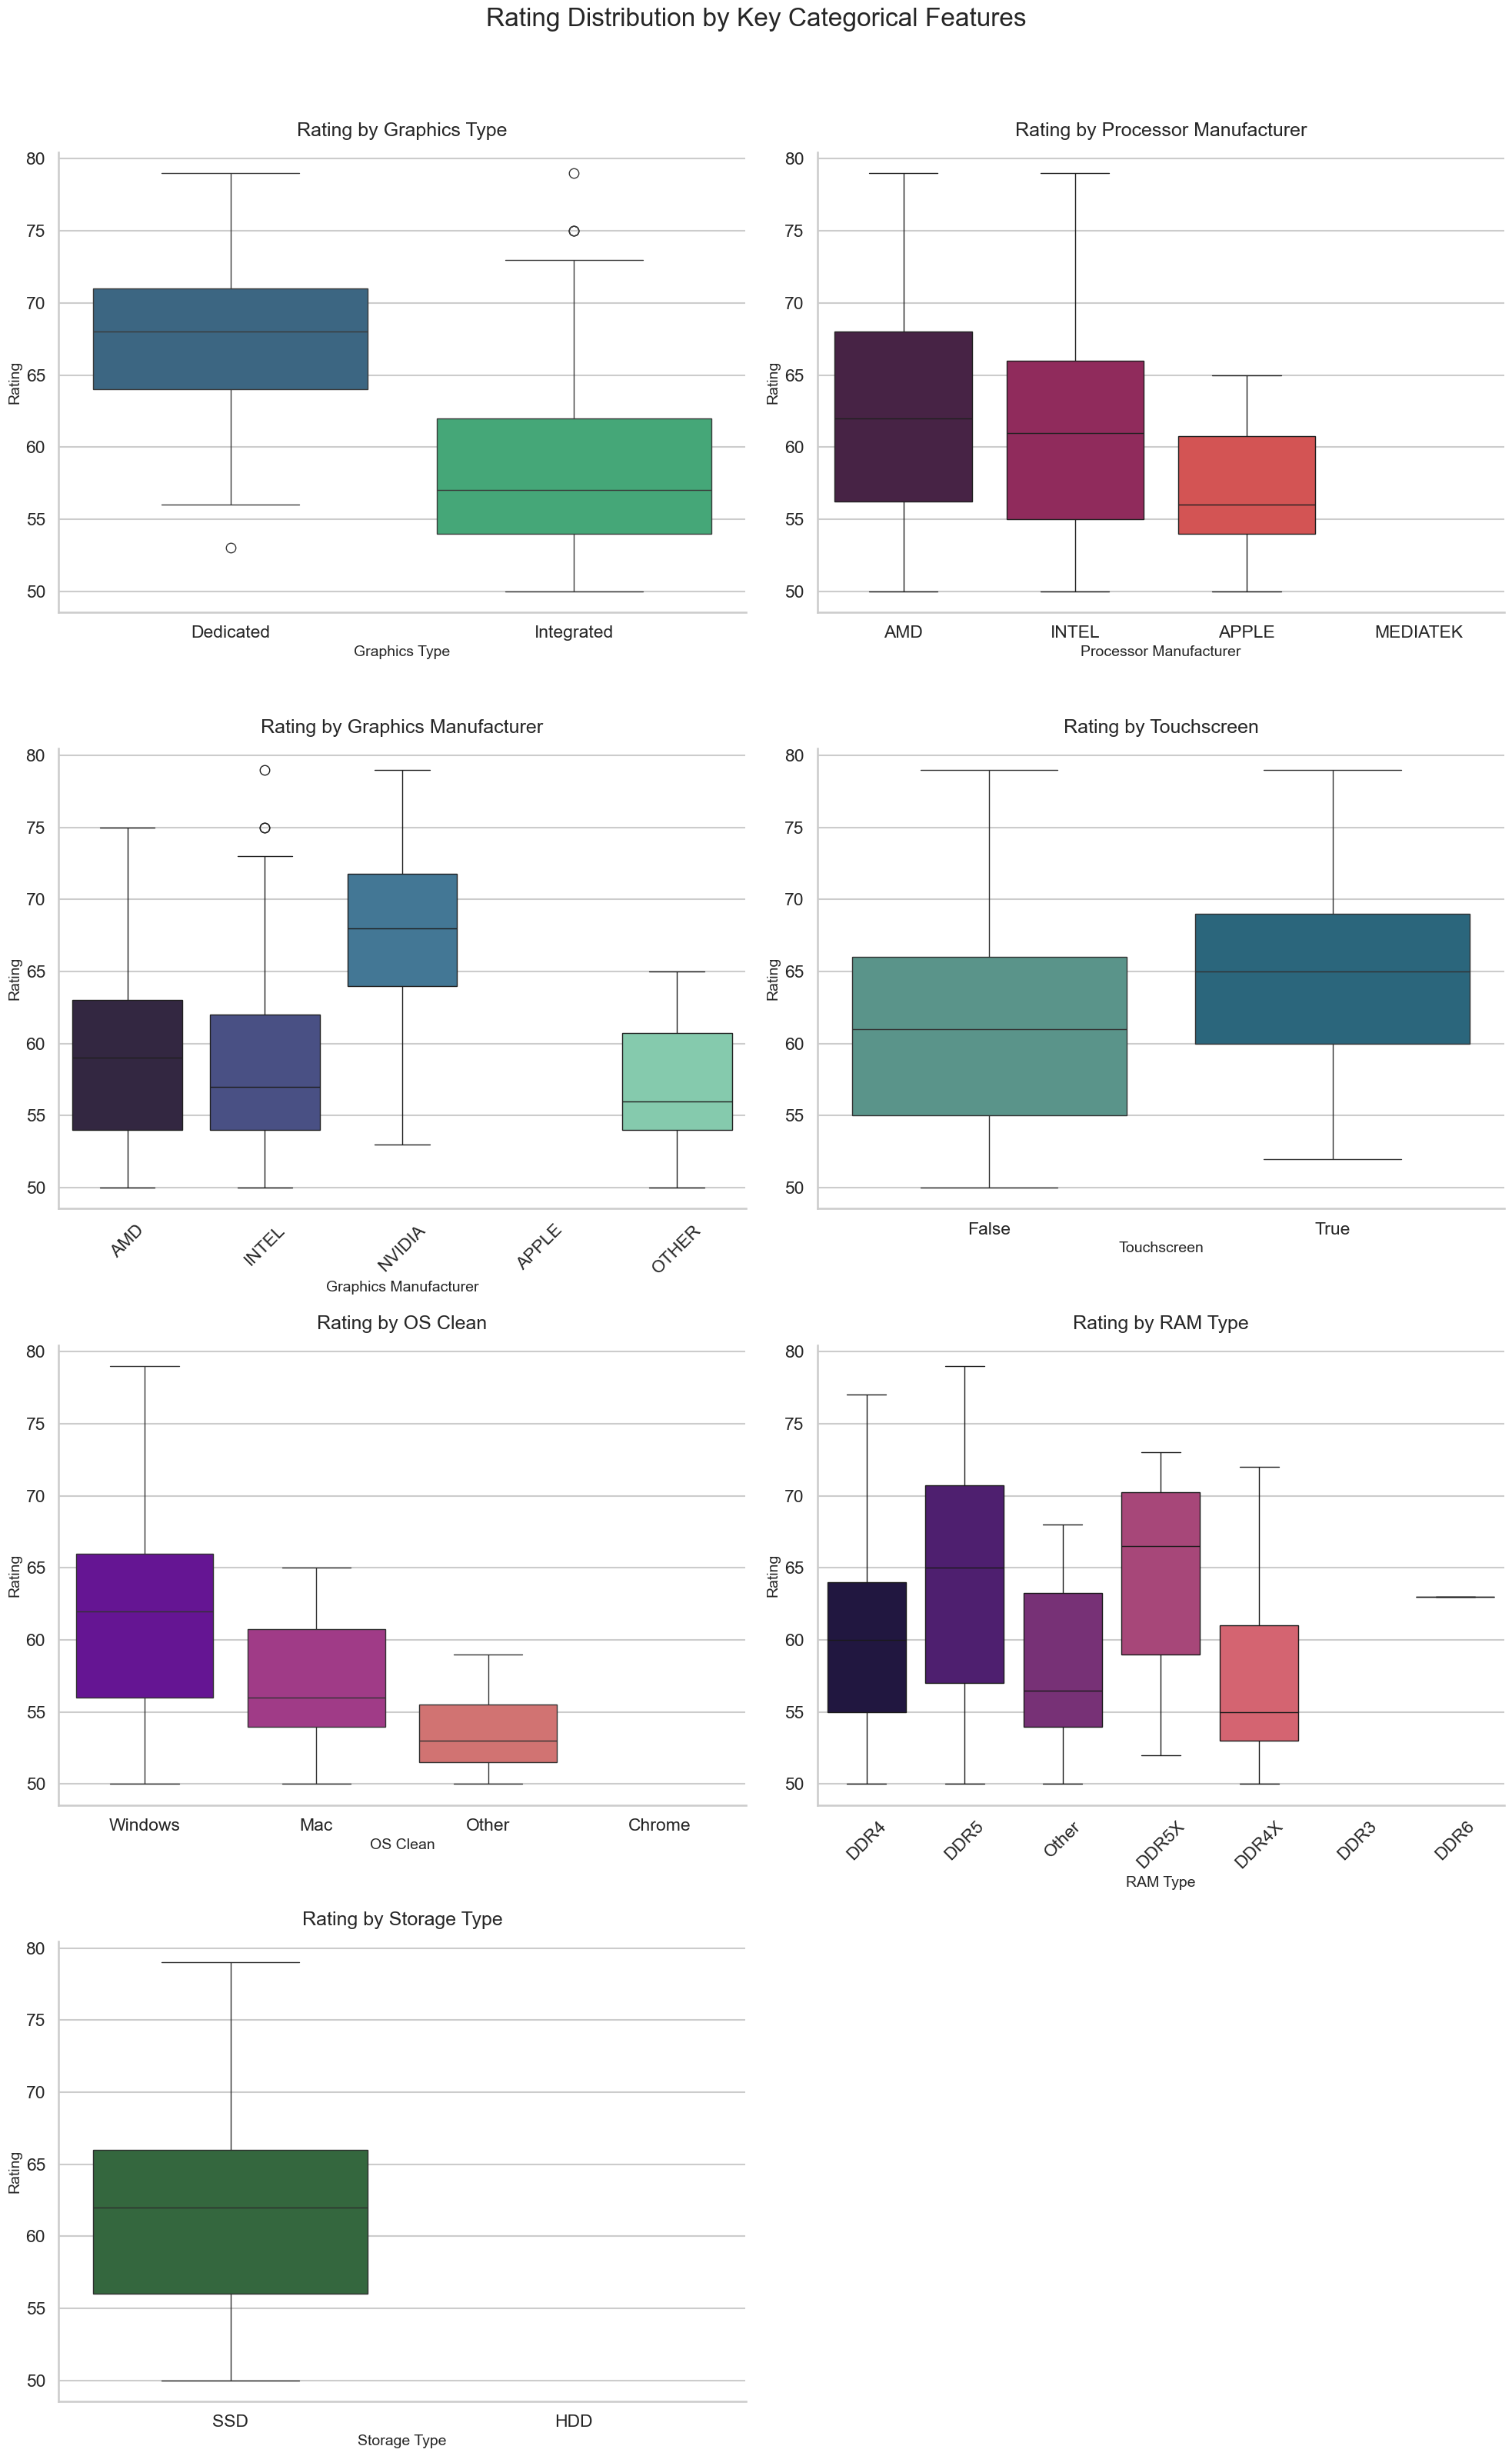

In [50]:
# Visualize Rating distribution by key categorical features
sns.set_style("whitegrid")
sns.set_context("talk")
fig, axes = plt.subplots(4, 2, figsize=(20, 32))
fig.suptitle('Rating Distribution by Key Categorical Features', fontsize=24, y=1.0)

axes = axes.flatten()

categorical_features = [
    'Graphics_Type', 'Processor_Manufacturer', 'Graphics_Manufacturer',
    'Touchscreen', 'OS_Clean', 'RAM_Type', 'Storage_Type'
]

palettes = ['viridis', 'rocket', 'mako', 'crest', 'plasma', 'magma', 'cubehelix']

for i, feature in enumerate(categorical_features):
    sns.boxplot(
        ax=axes[i],
        x=feature,
        y='Rating',
        data=df,
        hue=feature,
        palette=palettes[i],
        legend=False
    )
    axes[i].set_title(f'Rating by {feature.replace("_", " ")}', fontsize=18, pad=15)
    axes[i].set_xlabel(feature.replace("_", " "), fontsize=14)
    axes[i].set_ylabel('Rating', fontsize=14)
    if len(df[feature].unique()) > 4:
        axes[i].tick_params(axis='x', rotation=45)

fig.delaxes(axes[7])

sns.despine()
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

**Analysis:** The box plots show a clear difference in the median rating between 'Dedicated' and 'Integrated' graphics types. To confirm this statistically, we will use an ANOVA test on our categorical features.

In [51]:
# ANOVA test to find the most significant factor for 'Rating'
anova_results = {}
categorical_features = ['Graphics_Type', 'Processor_Manufacturer', 'Graphics_Manufacturer', 
                        'Touchscreen', 'OS_Clean', 'RAM_Type', 'Storage_Type']

for feature in categorical_features:
    groups = [df['Rating'][df[feature] == val].dropna() for val in df[feature].unique() if not df['Rating'][df[feature] == val].dropna().empty]
    if len(groups) > 1:
        f_stat, p_val = stats.f_oneway(*groups)
        anova_results[feature] = {'f_statistic': f_stat, 'p_value': p_val}

best_measure = min(anova_results, key=lambda k: anova_results[k]['p_value'])

print("ANOVA Test Results: Feature Significance on Laptop Rating\n" + "="*60)
print(f"{'Feature':<25} | {'F-statistic':<15} | {'p-value':<15}")
print("-" * 60)

sorted_results = sorted(anova_results.items(), key=lambda item: item[1]['p_value'])

for feature, details in sorted_results:
    f_stat = details['f_statistic']
    p_val = details['p_value']
    if p_val < 0.001:
        p_val_str = "< 0.001"
    else:
        p_val_str = f"{p_val:.4f}"
    print(f"{feature:<25} | {f_stat:<15.2f} | {p_val_str:<15}")

print("-" * 60)
print(f"\nConclusion: '{best_measure}' is the most statistically significant feature for imputation.")

ANOVA Test Results: Feature Significance on Laptop Rating
Feature                   | F-statistic     | p-value        
------------------------------------------------------------
Graphics_Type             | 480.99          | < 0.001        
Graphics_Manufacturer     | 157.81          | < 0.001        
RAM_Type                  | 17.66           | < 0.001        
OS_Clean                  | 11.03           | < 0.001        
Touchscreen               | 13.97           | < 0.001        
Processor_Manufacturer    | 5.13            | 0.0061         
------------------------------------------------------------

Conclusion: 'Graphics_Type' is the most statistically significant feature for imputation.


### 4.1.1. Correlation Analysis for Numeric Features

To assess the relationship between our new numeric features and the 'Rating', we can use a correlation matrix.

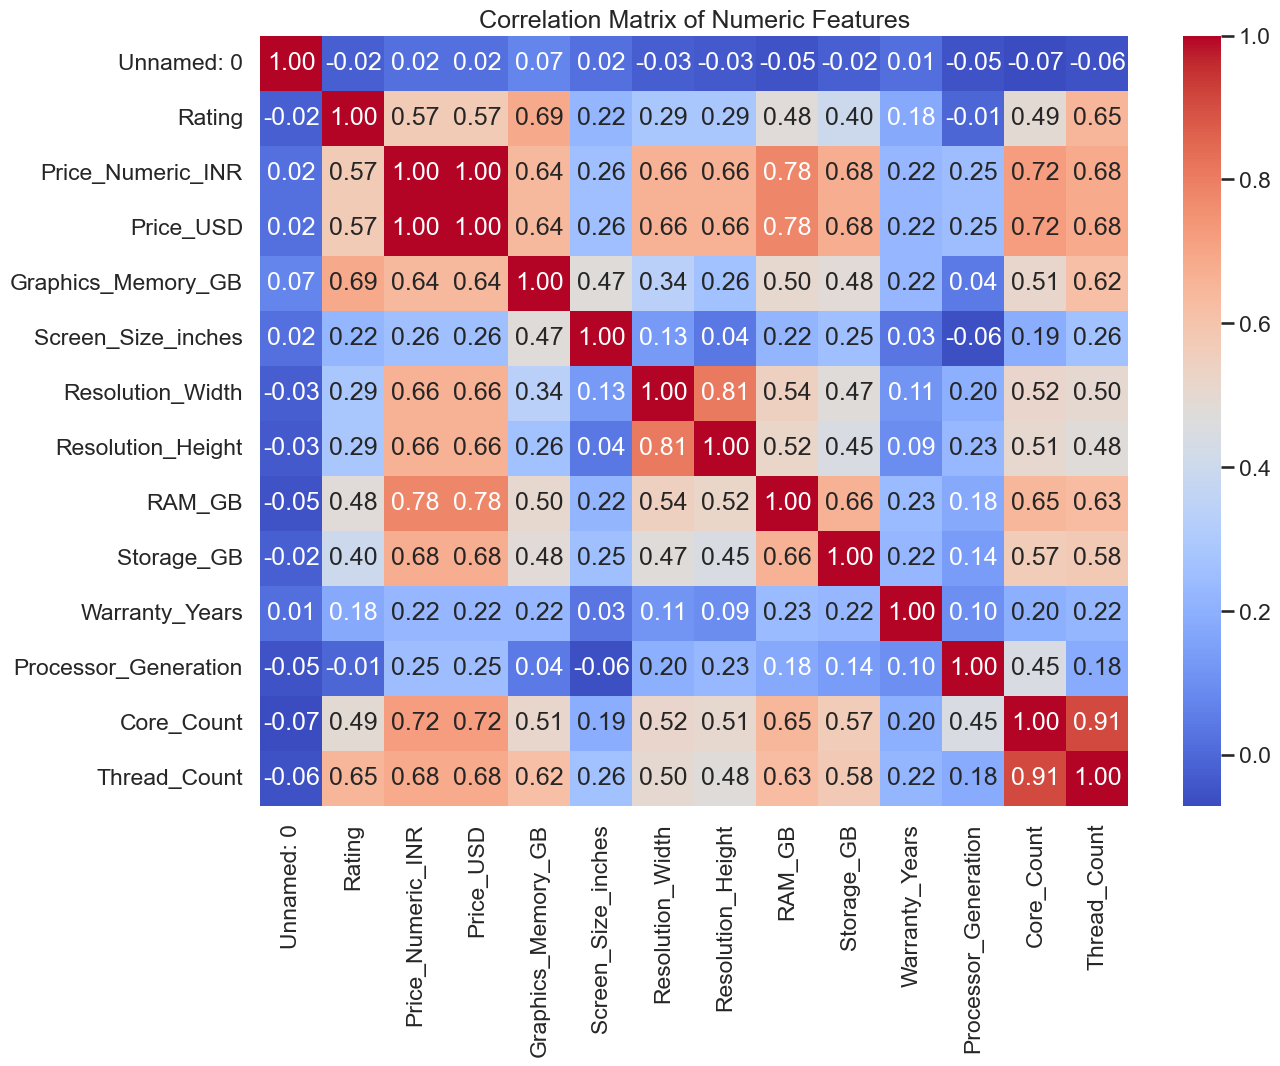


Correlation with Rating:
Rating                  1.000000
Graphics_Memory_GB      0.686379
Thread_Count            0.650002
Price_USD               0.571033
Price_Numeric_INR       0.571033
Core_Count              0.492144
RAM_GB                  0.480751
Storage_GB              0.400913
Resolution_Height       0.288911
Resolution_Width        0.286416
Screen_Size_inches      0.220843
Warranty_Years          0.176049
Processor_Generation   -0.005052
Unnamed: 0             -0.023301
Name: Rating, dtype: float64


In [52]:
# Select only numeric columns for correlation matrix
numeric_cols = df.select_dtypes(include=np.number).columns
correlation_matrix = df[numeric_cols].corr()

# Plot the heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numeric Features')
plt.show()

print("\nCorrelation with Rating:")
print(correlation_matrix['Rating'].sort_values(ascending=False))

### 4.2. Imputing 'Rating' Values

**Decision:** The ANOVA test confirms that **'Graphics_Type'** remains the most significant categorical feature. The correlation matrix also shows that `Graphics_Memory_GB` (which is directly tied to `Graphics_Type`) has the highest correlation with `Rating`. Therefore, imputing the missing 'Rating' values using the median rating for each 'Graphics_Type' is a sound and justifiable strategy.

In [53]:
# Impute missing 'Rating' using the median grouped by 'Graphics_Type'
df['Rating'] = df.groupby('Graphics_Type')['Rating'].transform(lambda x: x.fillna(x.median()))

print("Missing 'Rating' values have been imputed.")
print(f"Remaining nulls in 'Rating': {df['Rating'].isnull().sum()}")

Missing 'Rating' values have been imputed.
Remaining nulls in 'Rating': 0


## 5. Finalizing the Cleaned Dataset

Finally, we will drop the original, now redundant, columns and review the structure of our cleaned dataset. We will keep the 'Model' column as a unique identifier for traceability and further specific analysis.

In [ ]:
# Drop original and intermediate columns
columns_to_drop = [
    'Unnamed: 0', 'Price', 'Price_Cleaned', 'Price_Numeric_INR',
    'Generation', 'Core', 'Ram', 'SSD', 'Display', 'Graphics', 'OS', 'Warranty'
]
df_cleaned = df.drop(columns=columns_to_drop)

# Reorder columns for better readability
column_order = [
    'Model', 'Manufacturer', 'Price_USD', 'Rating', 'OS_Clean', 
    'Processor_Manufacturer', 'Processor_Generation', 'Core_Count', 'Thread_Count',
    'RAM_GB', 'RAM_Type', 'Storage_GB', 'Storage_Type',
    'Graphics_Manufacturer', 'Graphics_Type', 'Graphics_Memory_GB',
    'Screen_Size_inches', 'Resolution_Width', 'Resolution_Height', 'Touchscreen',
    'Warranty_Years'
]
df_cleaned = df_cleaned[column_order]

print("Final Cleaned Dataset Information:")
df_cleaned.info()
print("\nSample of the cleaned data:")
df_cleaned.head()

Final Cleaned Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 896 entries, 0 to 895
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Model                   896 non-null    object 
 1   Manufacturer            896 non-null    object 
 2   Price_USD               896 non-null    float64
 3   Rating                  896 non-null    float64
 4   OS_Clean                896 non-null    object 
 5   Processor_Manufacturer  896 non-null    object 
 6   Processor_Generation    896 non-null    float64
 7   Core_Count              896 non-null    float64
 8   Thread_Count            896 non-null    float64
 9   RAM_GB                  896 non-null    float64
 10  RAM_Type                896 non-null    object 
 11  Storage_GB              896 non-null    int64  
 12  Storage_Type            896 non-null    object 
 13  Graphics_Manufacturer   896 non-null    object 
 14  Graphic

,Model,Manufacturer,Price_USD,Rating,OS_Clean,Processor_Manufacturer,Processor_Generation,Core_Count,Thread_Count,RAM_GB,...,Storage_GB,Storage_Type,Graphics_Manufacturer,Graphics_Type,Graphics_Memory_GB,Screen_Size_inches,Resolution_Width,Resolution_Height,Touchscreen,Warranty_Years
0,HP Victus 15-fb0157AX Gaming Laptop (AMD Ryzen...,HP,604.79,70.0,Windows,AMD,5.0,6.0,12.0,8.0,...,512,SSD,AMD,Dedicated,4.0,15.6,1920.0,1080.0,True,1.0
1,Tecno Megabook T1 Laptop (11th Gen Core i3/ 8G...,TECNO,287.88,56.0,Windows,INTEL,11.0,2.0,4.0,8.0,...,512,SSD,INTEL,Integrated,0.0,15.6,1920.0,1080.0,False,1.0
2,Lenovo V15 G4 ‎82YU00W7IN Laptop (AMD Ryzen 3 ...,LENOVO,323.87,55.0,Windows,AMD,7.0,4.0,8.0,8.0,...,512,SSD,AMD,Integrated,0.0,15.6,1920.0,1080.0,False,1.0
3,Samsung Galaxy Book2 Pro 13 Laptop (12th Gen C...,SAMSUNG,839.88,60.0,Windows,INTEL,12.0,12.0,16.0,16.0,...,512,SSD,INTEL,Integrated,0.0,13.3,1080.0,1920.0,False,1.0
4,Xiaomi Redmi G Pro 2024 Gaming Laptop (14th Ge...,XIAOMI,1235.88,78.0,Windows,INTEL,14.0,24.0,32.0,16.0,...,1000,SSD,NVIDIA,Dedicated,8.0,16.1,2560.0,1600.0,False,1.0


In [55]:
# Save the cleaned dataframe to a CSV file for the next stage of analysis
df_cleaned.to_csv('../data/processed/cleaned_laptops.csv', index=False)

print("Cleaned data saved to 'cleaned_laptops.csv'")

Cleaned data saved to 'cleaned_laptops.csv'
